In [8]:
import pm4py
import io
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.bpmn import visualizer as bpmn_vis
from pm4py.statistics.traces.generic.log import case_statistics
from IPython.display import Markdown, display

In [20]:
log_domestic = pm4py.read_xes('Data/DomesticDeclarations.xes')
log_international = pm4py.read_xes('Data/InternationalDeclarations.xes')

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

Zunächst wird durch die Funktion "get_all_case_durations" die Dauer (in Sekunden) für die Prozessdurchläufe berechnet. Der Zeitstempel der Aktivitäten wird dafür verwendet, um die Differenz zwischen dem Start und dem Ende des jeweiligen Prozesses zu ermitteln.

In [21]:
dom_case_duration = pm4py.get_all_case_durations(log_domestic, activity_key='concept:name', case_id_key='case:concept:name',timestamp_key='time:timestamp')
int_case_duration = pm4py.get_all_case_durations(log_international, activity_key='concept:name', case_id_key='case:concept:name',timestamp_key='time:timestamp')

Die entstandene Liste dient als Grundlage, um weitere Analysen bzgl. der Dauer der Prozessdurchläufe durchzuführen. So lässt sich anschließend beispielsweise der Durchschnitt und Median berechnen.

In [22]:
# Funktion zur Umrechnung von Millisekunden in Stunden
def convert_to_hours(ms):
    return round(ms / 3600, 1)

# Berechnung von Durchschnitt, Median und Standardabweichung in Millisekunden
mean_dom = np.mean(dom_case_duration)
median_dom = np.median(dom_case_duration)
std_dom = np.std(dom_case_duration)

mean_int = np.mean(int_case_duration)
median_int = np.median(int_case_duration)
std_int = np.std(int_case_duration)

# Umrechnung der Ergebnisse in Stunden
mean_dom_hours = convert_to_hours(mean_dom)
median_dom_hours = convert_to_hours(median_dom)
std_dom_hours = convert_to_hours(std_dom)

mean_int_hours = convert_to_hours(mean_int)
median_int_hours = convert_to_hours(median_int)
std_int_hours = convert_to_hours(std_int)

# Erstellen eines DataFrames für die Ergebnisse
df = pd.DataFrame({
    "Prozesstyp": ["Inländische Reiseanträge", "Internationale Reiseanträge"],
    "Durchschnitt": [mean_dom_hours, mean_int_hours],
    "Median": [median_dom_hours, median_int_hours],
    "Standardabweichung": [std_dom_hours, std_int_hours]
})

# Überschrift hinzufügen
table_title = "### Dauer Prozessdurchläufe (in Stunden)\n"

# Konvertieren zu Markdown
markdown_table = table_title + df.to_markdown(index=False)

# Anzeige der Markdown-Tabelle
display(Markdown(markdown_table))

### Dauer Prozessdurchläufe (in Stunden)
| Prozesstyp                  |   Durchschnitt |   Median |   Standardabweichung |
|:----------------------------|---------------:|---------:|---------------------:|
| Inländische Reiseanträge    |          276.6 |    175.9 |                408.5 |
| Internationale Reiseanträge |         2074.9 |   1585.3 |               1880.3 |

Die Tabelle verdeutlicht, dass die Durchlaufzeiten für internationale Reiseanträge im Vergleich zu inländischen Anträgen erheblich länger sind. Zudem weisen beide Prozessarten eine hohe Standardabweichung auf, was auf signifikante Schwankungen in den Durchlaufzeiten hinweist.

Um diese Variabilität detaillierter zu veranschaulichen, wird im folgenden Abschnitt ein Histogramm erstellt, das die Verteilung der Durchlaufzeiten visualisiert.

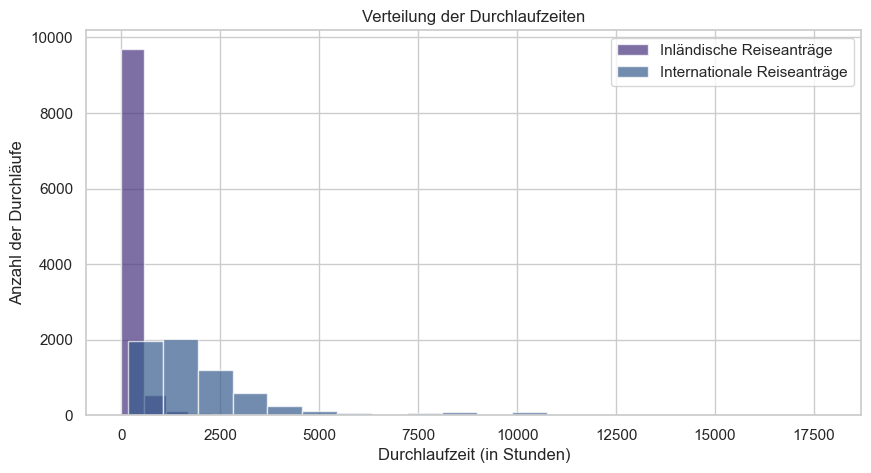

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setzen des Seaborn-Themes mit der Viridis-Farbpalette
sns.set_theme(palette="viridis", style="whitegrid")

# Verteilung der Prozessdurchläufe für Domestic und International
plt.figure(figsize=(10, 5))
plt.hist([d / 3600 for d in dom_case_duration], bins=20, alpha=0.7, label='Inländische Reiseanträge')
plt.hist([d / 3600 for d in int_case_duration], bins=20, alpha=0.7, label='Internationale Reiseanträge')
plt.xlabel('Durchlaufzeit (in Stunden)')
plt.ylabel('Anzahl der Durchläufe')
plt.title('Verteilung der Durchlaufzeiten')
plt.legend()
plt.savefig("./Data/histogramm_case_durations.svg", format='svg', bbox_inches='tight')
plt.show()

Zusätzlich ist interessant zu schauen, ob sich die Prozessdurchlaufzeiten über die Jahre verändert haben. Dafür wird eine entsprechende Grafik erstellt.

Zunächst wird eine Funktion definiert, um die Durchlaufzeiten für die Event-Logs zu berechnen.

In [14]:
def calculate_case_durations(log):
    durations = pm4py.get_all_case_durations(log, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
    return durations

Um die Prozessdurchlaufzeiten nach Jahr zu analysieren, wird aus den vorhandenen Zeitstempeln eine neue Spalte Year im DataFrame erstellt.

In [15]:
log_domestic['Year'] = pd.to_datetime(log_domestic['time:timestamp']).dt.year
log_international['Year'] = pd.to_datetime(log_international['time:timestamp']).dt.year

Anschließend findet eine Filterung auf die Jahre 2017, 2018 und 2019 für inländische und internationale Reiseanträge statt.

In [16]:
durations_2017_domestic = calculate_case_durations(log_domestic[log_domestic['Year'] == 2017])
durations_2018_domestic = calculate_case_durations(log_domestic[log_domestic['Year'] == 2018])
durations_2019_domestic = calculate_case_durations(log_domestic[log_domestic['Year'] == 2019])

durations_2017_international = calculate_case_durations(log_international[log_international['Year'] == 2017])
durations_2018_international = calculate_case_durations(log_international[log_international['Year'] == 2018])
durations_2019_international = calculate_case_durations(log_international[log_international['Year'] == 2019])

Daraufhin wird eine Umwandlung der Prozessdurchlaufzeiten in Stunden durchgeführt.

In [17]:
# Umwandlung der Prozessdurchlaufzeiten in Stunden
durations_2017_domestic_hours = [convert_to_hours(d) for d in durations_2017_domestic]
durations_2018_domestic_hours = [convert_to_hours(d) for d in durations_2018_domestic]
durations_2019_domestic_hours = [convert_to_hours(d) for d in durations_2019_domestic]

durations_2017_international_hours = [convert_to_hours(d) for d in durations_2017_international]
durations_2018_international_hours = [convert_to_hours(d) for d in durations_2018_international]
durations_2019_international_hours = [convert_to_hours(d) for d in durations_2019_international]

Für alle Jahre wird dann der Median berechnet.

In [18]:
# Berechnung der Mediane für jedes Jahr
median_2017_domestic = np.median(durations_2017_domestic_hours)
median_2018_domestic = np.median(durations_2018_domestic_hours)
median_2019_domestic = np.median(durations_2019_domestic_hours)

median_2017_international = np.median(durations_2017_international_hours)
median_2018_international = np.median(durations_2018_international_hours)
median_2019_international = np.median(durations_2019_international_hours)

Darauf aufbauend wird dann die Grafik erstellt.

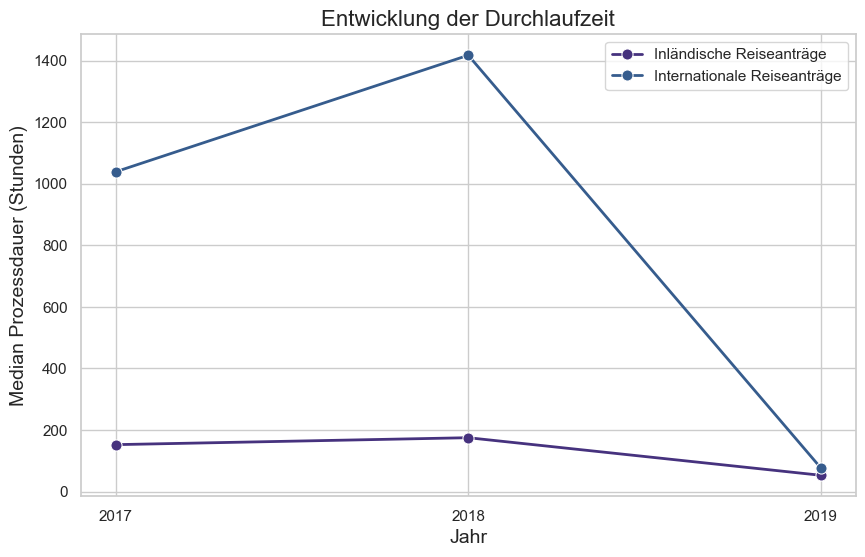

In [19]:
# Jahre und entsprechende Medianwerte
years = ['2017', '2018', '2019']
medians_domestic = [median_2017_domestic, median_2018_domestic, median_2019_domestic]
medians_international = [median_2017_international, median_2018_international, median_2019_international]

# Setzen des Seaborn-Themes mit der Viridis-Farbpalette
sns.set_theme(palette="viridis", style="whitegrid")

# Erstellen des Liniendiagramms
plt.figure(figsize=(10, 6))
sns.lineplot(x=years, y=medians_domestic, marker='o', linestyle='-', linewidth=2, markersize=8, label='Inländische Reiseanträge')
sns.lineplot(x=years, y=medians_international, marker='o', linestyle='-', linewidth=2, markersize=8, label='Internationale Reiseanträge')

# Achsenbeschriftungen und Titel
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Median Prozessdauer (Stunden)', fontsize=14)
plt.title('Entwicklung der Durchlaufzeit', fontsize=16)

# Legende hinzufügen
plt.legend()

# Optionale Gitterlinien zur besseren Lesbarkeit
plt.grid(True)

plt.savefig("./Data/development_duration.svg", format='svg', bbox_inches='tight')

# Anzeige des Graphen
plt.show()